In [ ]:
from Bio.SeqUtils import gc_fraction
from itertools import product
import os, sys
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# load data

#### INCORRECT COLUMN NAME note

Columns DNA_1, DNA_2, DNA_3, and RNA_1, RNA_2, RNA_3 columns were named incorrectly. 

    DNA_1, DNA_2, DNA_3 = RNA_1, RNA_2, RNA_3

    RNA_1, RNA_2, RNA_3 = DNA_1, DNA_2, DNA_3
    
RATIO_1, RATIO_2, and RATIO_3 are correct

In [2]:
CSV = "/wynton/home/ahituv/fongsl/nullomers/data/mpra/PromoterNullomer_ABV20.csv"

df = pd.read_csv(CSV)

df.head()

,Unnamed: 0,ID,ID_ORIG,Unnamed: 3,CATEGORY,LOCATION,INSERT,Padded.Insert,DNA_1,RNA_1,...,BARCODES_3,Rep_count,avg,pv_scrm,expression,scrm_expression,scrm_Expression,pv_sv40,expression_sv40,Expression_sv40
0,1,>128412,128412,NaN,NULLOER,DISTAL,AACGCGTCGATAG,GGAGAACGCGTCGATAGGCCT,0.746318,0.758651,...,28.0,3,1.016011,5.930000e-39,Unchanged,Unchanged,DISTAL_Unchanged,0.739710,Unchanged,DISTAL_Unchanged
1,2,>128418,128418,6.0,NULLOER,DISTAL,ACGATTACGCGCG,GGAGACGATTACGCGCGGCCT,5.160221,3.230870,...,33.0,3,1.398864,1.100000e-63,Unchanged,Unchanged,DISTAL_Unchanged,0.063350,Unchanged,DISTAL_Unchanged
2,3,>128419,128419,1.0,NULLOER,MID,ACGATTACGCGCG,GCAGACGATTACGCGCGAGGC,2.265344,1.900710,...,35.0,3,1.272478,7.460000e-56,Unchanged,Unchanged,MID_Unchanged,0.090174,Unchanged,MID_Unchanged
3,4,>128421,128421,2.0,NULLOER,DISTAL,ACGCGTCGATAGG,GGAGACGCGTCGATAGGGCCT,0.782786,0.827351,...,27.0,3,0.895732,1.240000e-30,Unchanged,Unchanged,DISTAL_Unchanged,0.161035,Unchanged,DISTAL_Unchanged
4,5,>128424,128424,3.0,NULLOER,DISTAL,ACGCGTCGTACGG,GGAGACGCGTCGTACGGGCCT,0.888767,1.069103,...,27.0,3,0.976620,4.340000e-35,Unchanged,Unchanged,DISTAL_Unchanged,0.876263,Unchanged,DISTAL_Unchanged


## dropping columns

In [3]:
list(df)

['Unnamed: 0',
 'ID',
 'ID_ORIG',
 'Unnamed: 3',
 'CATEGORY',
 'LOCATION',
 'INSERT',
 'Padded.Insert',
 'DNA_1',
 'RNA_1',
 'RATIO_1',
 'BARCODES_1',
 'DNA_2',
 'RNA_2',
 'RATIO_2',
 'BARCODES_2',
 'DNA_3',
 'RNA_3',
 'RATIO_3',
 'BARCODES_3',
 'Rep_count',
 'avg',
 'pv_scrm',
 'expression',
 'scrm_expression',
 'scrm_Expression',
 'pv_sv40',
 'expression_sv40',
 'Expression_sv40']

In [4]:
drop_cols = ['Unnamed: 0', "ID"]
df = df.drop(columns=drop_cols)
#df = df.loc[df["CATEGORY"]!= "CONTROL_SCRM"] # no insert information

df.head()

,ID_ORIG,Unnamed: 3,CATEGORY,LOCATION,INSERT,Padded.Insert,DNA_1,RNA_1,RATIO_1,BARCODES_1,...,BARCODES_3,Rep_count,avg,pv_scrm,expression,scrm_expression,scrm_Expression,pv_sv40,expression_sv40,Expression_sv40
0,128412,NaN,NULLOER,DISTAL,AACGCGTCGATAG,GGAGAACGCGTCGATAGGCCT,0.746318,0.758651,0.983743,28.0,...,28.0,3,1.016011,5.930000e-39,Unchanged,Unchanged,DISTAL_Unchanged,0.739710,Unchanged,DISTAL_Unchanged
1,128418,6.0,NULLOER,DISTAL,ACGATTACGCGCG,GGAGACGATTACGCGCGGCCT,5.160221,3.230870,1.597161,32.0,...,33.0,3,1.398864,1.100000e-63,Unchanged,Unchanged,DISTAL_Unchanged,0.063350,Unchanged,DISTAL_Unchanged
2,128419,1.0,NULLOER,MID,ACGATTACGCGCG,GCAGACGATTACGCGCGAGGC,2.265344,1.900710,1.191841,32.0,...,35.0,3,1.272478,7.460000e-56,Unchanged,Unchanged,MID_Unchanged,0.090174,Unchanged,MID_Unchanged
3,128421,2.0,NULLOER,DISTAL,ACGCGTCGATAGG,GGAGACGCGTCGATAGGGCCT,0.782786,0.827351,0.946136,26.0,...,27.0,3,0.895732,1.240000e-30,Unchanged,Unchanged,DISTAL_Unchanged,0.161035,Unchanged,DISTAL_Unchanged
4,128424,3.0,NULLOER,DISTAL,ACGCGTCGTACGG,GGAGACGCGTCGTACGGGCCT,0.888767,1.069103,0.831320,25.0,...,27.0,3,0.976620,4.340000e-35,Unchanged,Unchanged,DISTAL_Unchanged,0.876263,Unchanged,DISTAL_Unchanged


## GC content
sum of g's and c's. Does not consider GC dinucleotides. 

In [13]:
def count_dinucleotide(sequence):
    
    """
    input 
        sequence (str)
    method
        1. instantiate GC count variable, last_dinucleotide variable. Upper() sequence
        2. iterate, step-size=1, through sequence, counting GC/CG
        3. if last dinucleotide pair was not in the previous step, count this dinucleotide. 
            Set the last_dinuc step at this index. 
        4. if the last dinucleotide pair WAS adjacent to this step, do not count, continue. 
    
    return count of GC dinucleotide 
        
    """
    #1
    gc_dinuc_count, last_dinuc = 0, 0
    sequence = sequence.upper()
    
    #2
    for n in range(len(sequence)+1):  

        seq=sequence[n:n+2]  #get index of sequence and next nucleotide
        
        if seq=="GC" or seq=="CG":
            
            # 3
            if last_dinuc!=n-1:  # if last dinucleotide was not the previous step
                gc_dinuc_count +=1
                last_dinuc = n
                #print("Count sequence dinucleotide")

            # 4  handle cases where gc isn't dinucleotide, but trinucleotide
            elif last_dinuc ==n-1: 
                #print("last sequence was dinucleotide")
                continue
                
    return gc_dinuc_count

def countDinuc(df, seq_col):
    """
    count the frequency of G's and C's, the dinucleotide frequency
    
    input
        df (pd dataframe obj) - dataframe w/ nullomer data, sequences
        seq_col (str) - name of the dataframe column w/ the sequence str
    
    method
        1. remove any rows w/ no sequence info
        2. quantify %GC with SeqUtils.gc_fraction function
        3. calculate dinucleotide content using a custom script
        
    return 
        test (pd dataframe) - copy of the input dataframe w/ %gc and dinucleotide count
        
    """
    #1
    test = df.loc[df[seq_col].astype(str) != "nan"].copy()
    
    #2
    test["%GC"] = test[seq_col].apply(lambda x: gc_fraction(x))  # SeqUtils
    
    #3
    test["GC_dinuc"] = test[seq_col].apply(lambda x: count_dinucleotide(x))  # custom function
    
    return test

In [7]:
# test dinucleotide counting

x, n= "AACGCGTCGATAG", 2
count_dinucleotide(x)

3

In [14]:
# remove rows w/ no inserts

test = countDinuc(df,"INSERT")

test.head()

,ID_ORIG,Unnamed: 3,CATEGORY,LOCATION,INSERT,Padded.Insert,DNA_1,RNA_1,RATIO_1,BARCODES_1,...,avg,pv_scrm,expression,scrm_expression,scrm_Expression,pv_sv40,expression_sv40,Expression_sv40,%GC,GC_dinuc
0,128412,NaN,NULLOER,DISTAL,AACGCGTCGATAG,GGAGAACGCGTCGATAGGCCT,0.746318,0.758651,0.983743,28.0,...,1.016011,5.930000e-39,Unchanged,Unchanged,DISTAL_Unchanged,0.739710,Unchanged,DISTAL_Unchanged,0.538462,3
1,128418,6.0,NULLOER,DISTAL,ACGATTACGCGCG,GGAGACGATTACGCGCGGCCT,5.160221,3.230870,1.597161,32.0,...,1.398864,1.100000e-63,Unchanged,Unchanged,DISTAL_Unchanged,0.063350,Unchanged,DISTAL_Unchanged,0.615385,3
2,128419,1.0,NULLOER,MID,ACGATTACGCGCG,GCAGACGATTACGCGCGAGGC,2.265344,1.900710,1.191841,32.0,...,1.272478,7.460000e-56,Unchanged,Unchanged,MID_Unchanged,0.090174,Unchanged,MID_Unchanged,0.615385,3
3,128421,2.0,NULLOER,DISTAL,ACGCGTCGATAGG,GGAGACGCGTCGATAGGGCCT,0.782786,0.827351,0.946136,26.0,...,0.895732,1.240000e-30,Unchanged,Unchanged,DISTAL_Unchanged,0.161035,Unchanged,DISTAL_Unchanged,0.615385,2
4,128424,3.0,NULLOER,DISTAL,ACGCGTCGTACGG,GGAGACGCGTCGTACGGGCCT,0.888767,1.069103,0.831320,25.0,...,0.976620,4.340000e-35,Unchanged,Unchanged,DISTAL_Unchanged,0.876263,Unchanged,DISTAL_Unchanged,0.692308,3


In [15]:
df.shape, test.shape

((12961, 27), (12711, 29))

# plot GC dinucleotide, GC frequency

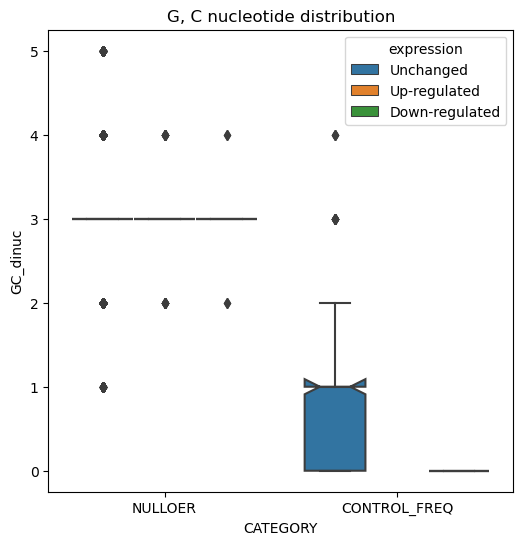

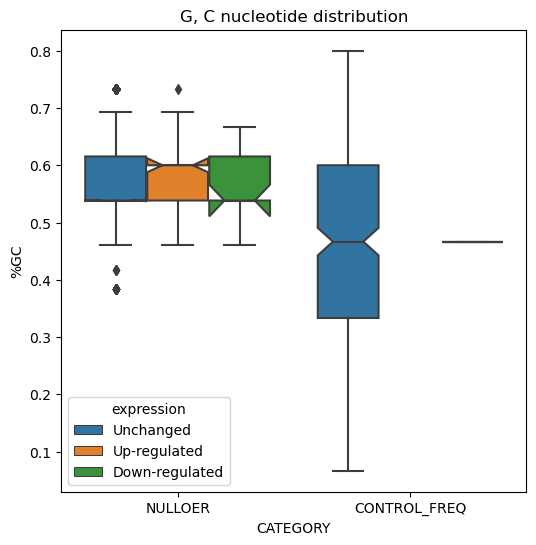

In [12]:
ys = ["GC_dinuc", "%GC",]
for y in ys:
    fig, ax = plt.subplots(figsize=(6,6))
    sns.boxplot(x='CATEGORY', y=y, data=test, 
               hue="expression",
                notch=True
              )
    ax.set(title="G, C nucleotide distribution")

# evaluating features. 

In [16]:
df.sort_values(by="ID_ORIG")
print(df.shape)

df.loc[df["ID_ORIG"]== 46077]

(12961, 27)


,ID_ORIG,Unnamed: 3,CATEGORY,LOCATION,INSERT,Padded.Insert,DNA_1,RNA_1,RATIO_1,BARCODES_1,...,BARCODES_3,Rep_count,avg,pv_scrm,expression,scrm_expression,scrm_Expression,pv_sv40,expression_sv40,Expression_sv40
12655,46077,-139992.0,CONTROL_FREQ,DISTAL,AAAATCTAGACAGAA,GGAGAAAATCTAGACAGAAGCCT,0.813061,0.957245,0.849376,25.0,...,27.0,3,0.983124,1.910000e-36,Unchanged,Unchanged,DISTAL_Unchanged,0.839988,Unchanged,DISTAL_Unchanged


# category x average expression, location

<AxesSubplot:xlabel='CATEGORY', ylabel='avg'>

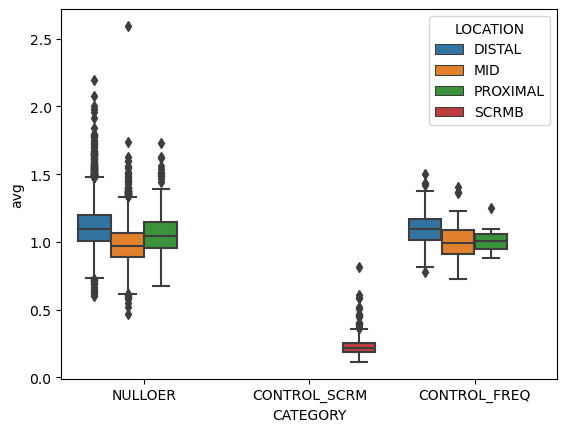

In [17]:
# plot three replicates only
threerep = df.loc[df['Rep_count']==3]
sns.boxplot(x = "CATEGORY", y = "avg", data=threerep, hue="LOCATION")

## category x average expression, stratified by upregulated, downregulated. 

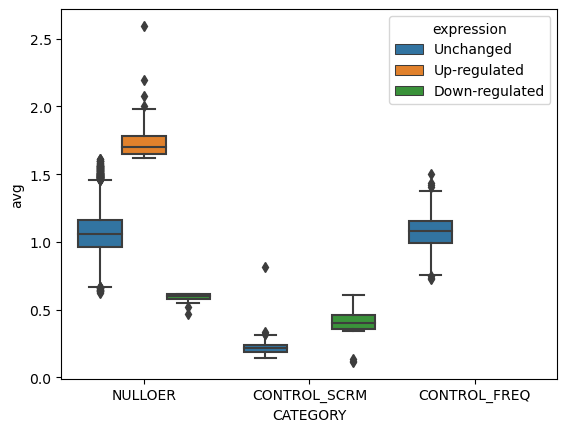

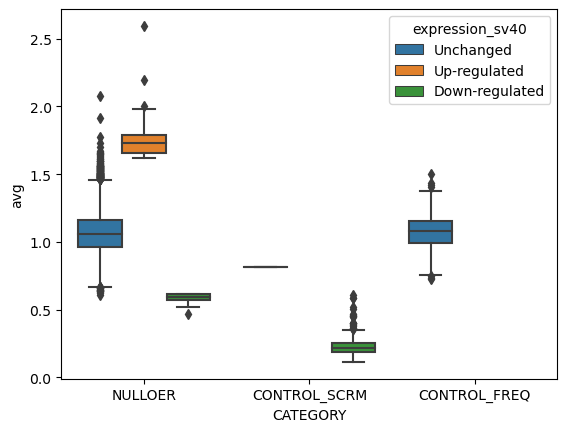

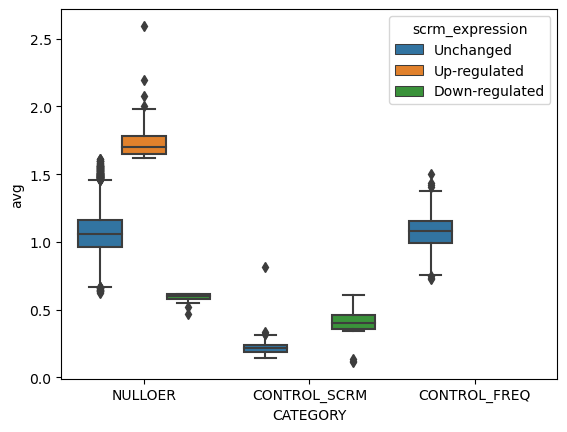

In [18]:
for e in ["expression", "expression_sv40", "scrm_expression"]:
    fig, ax = plt.subplots()
    sns.boxplot(x = "CATEGORY", y = "avg", data=threerep, hue=e)

## categorical expression calls and barcode counts

### sv40 expression

In [19]:
groupby_cols = ["CATEGORY", "expression_sv40", "scrm_expression"]
df.loc[df["Rep_count"]==3].groupby(groupby_cols)["ID_ORIG"].count()

CATEGORY      expression_sv40  scrm_expression
CONTROL_FREQ  Unchanged        Unchanged           243
CONTROL_SCRM  Down-regulated   Down-regulated       25
                               Unchanged           224
              Unchanged        Unchanged             1
NULLOER       Down-regulated   Down-regulated       12
              Unchanged        Down-regulated        1
                               Unchanged          9908
                               Up-regulated         15
              Up-regulated     Up-regulated         31
Name: ID_ORIG, dtype: int64

###  scrm expression

In [20]:
groupby_cols = ["CATEGORY", "scrm_expression"]
df.loc[df["Rep_count"]==3].groupby(groupby_cols)["ID_ORIG"].count()

CATEGORY      scrm_expression
CONTROL_FREQ  Unchanged           243
CONTROL_SCRM  Down-regulated       25
              Unchanged           225
NULLOER       Down-regulated       13
              Unchanged          9908
              Up-regulated         46
Name: ID_ORIG, dtype: int64

# get upregulated and down regulated nullomers

In [21]:
def makeDict(df):
 
    return df[["ID_ORIG","INSERT"]].drop_duplicates().set_index("ID_ORIG").to_dict()

In [22]:
def writeDict(dict_, outfile):
    with open(out, "w") as outfile:
        for _, seq_info in dict_.items():
            for i,sequence in seq_info.items():

                fa_line= f">{i}\n{sequence}\n"
                print(fa_line)
                outfile.write(fa_line)

    outfile.close()

# write .fasta file for blasting 

In [23]:
changed = df.loc[
                (df["CATEGORY"]=="NULLOER")
                & (df["expression"]!="Unchanged")
                & (df["Rep_count"]==3)
                ]

print(changed.shape)

(59, 27)


In [24]:
out = "/wynton/home/ahituv/fongsl/nullomers/data/mpra/change.fa"

nulloseq =  makeDict(changed)
writeDict(nulloseq, out)

>154195
CGTAAGCGTAACG

>140388
CGTCGATAGGCGCTG

>129951
ATCGGCGCGTACGAA

>130899
TACCGATCGACGCAG

>131124
TCGCGATACGCTAAG

>131869
CTATCGTTCGCGAAT

>133890
CCGATCGTACGACGA

>134970
GTTCGCGCGTCTAGA

>163440
ATACGCTAGTCCG

>145896
TCGCGCGATACTACG

>136059
GGTCGCGCGATACTA

>136353
GTCCGATCGTACGAC

>129393
CTATCGACGCGTTAA

>137050
TAATCCGACGCGCGT

>140658
GTCGATCGACCCGTG

>138792
TAATCGTACGAAGCG

>138894
TCGACCTATCGCGCA

>151908
TCGCGTGACGGTA

>162330
CGTTACGATCGCT

>152514
ACGCGATACGATC

>163560
ACGTACCGTCGTC

>141840
TTGCTACCGGTCGTA

>136503
CGATTACGCGCGAGT

>142815
CGTACCGGAACGATC

>144954
CCGATCGTACGACCG

>142500
CCGATCGTACGACTC

>144207
GCGATATTACGCGCA

>143439
TCGCGCGATACTATC

>135370
GCGGACGCGTACTAG

>146695
GCGCGATAGGTCGCT

>158600
TGCGTTACGATCG

>144123
CACTAGACGCGCGAA

>146769
CTGTATGCGCGACGG

>147731
CCGTACGTTCGCGAC

>148029
CGTCGCGACGTAGTC

>148719
ATCGTACGACCG

>147684
CCGGTCGACGCAATC

>133680
ACTCGTCCCGTACGA

>161529
TCGCACGCGATAA

>136845
GCGATATTACGCGGT

>152650
CGATATTCGAC

# knownmers

In [ ]:
knownmer = df.loc[
                (df["CATEGORY"]=="CONTROL_FREQ")
                #& (df["expression"]!="Unchanged")
                & (df["Rep_count"]==3)
                ]

knownmer

In [ ]:
out = "/wynton/home/ahituv/fongsl/nullomers/data/mpra/knownmer.fa"

knownmer_dict =  makeDict(knownmer)
writeDict(knownmer_dict, out)